In [1]:
import pandas as pd
import numpy as np
import biom
import h5py
import random

In [15]:
# load full table & metadata 
full_md = pd.read_csv('agp_metadata.tsv', sep='\t', index_col=0)
full_bt = biom.load_table('agp_samples.biom')

# filter metadata 
md_agp = full_md.loc[full_md.host_age >= 18] # remove individuals under 18
md_agp = md_agp.loc[md_agp.sample_type == 'Stool'] # only keep stool samples
full_bt.filter(ids_to_keep=md_agp.index)

# add sequencing depth to metadata 
md_agp['seq_depth'] = full_bt.to_dataframe().sum()

/tmp/ipykernel_10990/90247209.py:2: DtypeWarning: Columns (12,17,23,32,34,63,69,85,104,128,129,140,177) have mixed types. Specify dtype option on import or set low_memory=False.
  full_md = pd.read_csv('agp_metadata.tsv', sep='\t', index_col=0)


In [17]:
seq_df = pd.read_csv('newbloom.all.fna', names=['seqs'])
seqs = seq_df.loc[~seq_df['seqs'].str.startswith('>')]['seqs'].values

In [18]:
full_bt.filter(seqs, axis='observation', invert=True)

763235 x 14812 <class 'biom.table.Table'> with 3370764 nonzero entries (0% dense)

In [19]:
md_agp_sorted = md_agp.sort_values(by='seq_depth', ascending=False)
md_agp_dedup = md_agp_sorted.loc[~md_agp_sorted['host_subject_id'].duplicated()]

In [20]:
#12095 >1000
#11537 >5000
md_agp_5000_min = md_agp_dedup.loc[md_agp_dedup['seq_depth'] >= 5000]
full_bt.filter(ids_to_keep=md_agp_5000_min.index)

763235 x 11540 <class 'biom.table.Table'> with 2760005 nonzero entries (0% dense)

In [21]:
mdd_enriched = pd.read_csv('birdman_sig_plots/depression_enriched.csv', index_col=0)
mdd_hc_enriched = pd.read_csv('birdman_sig_plots/mdd_hc_enriched.csv', index_col=0)

In [22]:
mdd_agp = mdd_enriched.index.intersection(full_bt.ids(axis='observation'))
hc_agp = mdd_hc_enriched.index.intersection(full_bt.ids(axis='observation'))
mdd_enriched_bt = full_bt.filter(mdd_agp, axis='observation', inplace=False) 
hc_enriched_bt = full_bt.filter(hc_agp, axis='observation', inplace=False) 

In [23]:
filtered_df = pd.concat([mdd_enriched_bt.to_dataframe(), hc_enriched_bt.to_dataframe()]).T

In [24]:
def create_log_ratio_column(x, top_microbes, bottom_microbes): 
    if (x[top_microbes].sum() == 0) | (x[bottom_microbes].sum() == 0): 
        return np.nan
    return np.log(x[top_microbes].sum() / x[bottom_microbes].sum())

In [25]:
md_agp_5000_min['dep_lr'] = filtered_df.apply(create_log_ratio_column, axis=1, args=(mdd_agp, hc_agp))

/tmp/ipykernel_10990/3402888033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  md_agp_5000_min['dep_lr'] = filtered_df.apply(create_log_ratio_column, axis=1, args=(mdd_agp, hc_agp))


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

In [3]:
md_agp_5000_min = pd.read_csv('agp_metadata_filtered.tsv', sep='\t', index_col=0)
#md_agp_5000_min

/tmp/ipykernel_43994/1787168873.py:1: DtypeWarning: Columns (17,23,32,34,63,85,104,128,129,140,177) have mixed types. Specify dtype option on import or set low_memory=False.
  md_agp_5000_min = pd.read_csv('agp_metadata_filtered.tsv', sep='\t', index_col=0)


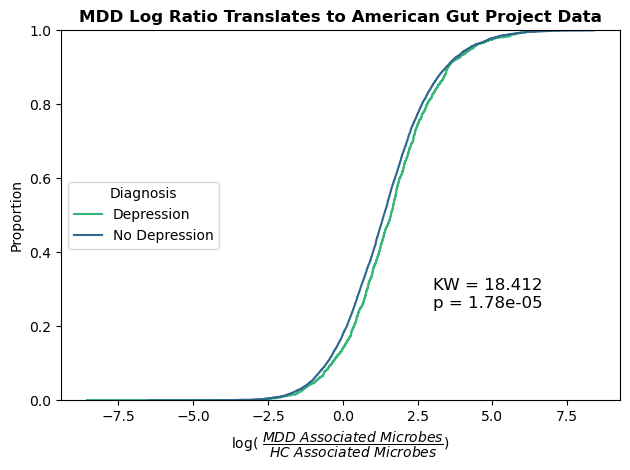

In [5]:
sns.ecdfplot(data=md_agp_5000_min, x='dep_lr', hue='mental_illness_type_depression', palette='viridis')
subset = md_agp_5000_min.loc[md_agp_5000_min['dep_lr'].notna()]
plt.legend(loc='center left', labels = ['Depression', 'No Depression'], title='Diagnosis')
plt.xlabel(r'log( $\dfrac{MDD~Associated~Microbes}{HC~Associated~Microbes}$)')
plt.title('MDD Log Ratio Translates to American Gut Project Data', fontdict={'weight': 'bold'})
kw = ss.kruskal(subset.loc[subset['mental_illness_type_depression']==True]['dep_lr'].values,
                subset.loc[subset['mental_illness_type_depression']==False]['dep_lr'].values)
plt.text(x=3, y=0.25, s='KW = ' + str(np.round(kw.statistic, 3)) + '\np = ' + str(np.format_float_scientific(kw.pvalue, 3)), 
         fontsize=12)
plt.tight_layout()
plt.savefig('fig3e.png', transparent=True)

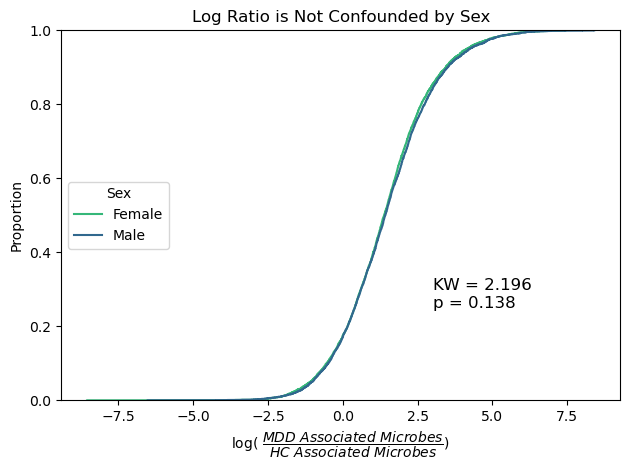

In [6]:
subset = md_agp_5000_min.loc[(md_agp_5000_min.sex.isin(['female', 'male'])) & 
                             (md_agp_5000_min['dep_lr'].notna())]
sns.ecdfplot(data=subset, x='dep_lr', hue='sex', palette='viridis')
plt.legend(loc='center left', labels = ['Female', 'Male'], title='Sex')
plt.xlabel(r'log( $\dfrac{MDD~Associated~Microbes}{HC~Associated~Microbes}$)')
plt.title('Log Ratio is Not Confounded by Sex')
kw = ss.kruskal(subset.loc[subset['sex']=='male']['dep_lr'].values,
                subset.loc[subset['sex']=='female']['dep_lr'].values)
plt.text(x=3, y=0.25, s='KW = ' + str(np.round(kw.statistic, 3)) + '\np = ' + str(np.round(kw.pvalue, 3)), 
         fontsize=12)
plt.tight_layout()
plt.savefig('fig3f.pdf')

In [32]:
md_agp_5000_min.to_csv('agp_metadata_filtered.tsv', sep='\t')
f = h5py.File('agp_table_filtered.biom', 'w')
full_bt.to_hdf5(f, 'tulsa')
f.close()

In [18]:
def do_ridge(df, md, column_name, random_state= 2, alpha=0.01, l1_ratio=None):
    X = df
    y = md.loc[X.index].get(column_name)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    sel_ = SelectFromModel(Ridge(alpha=alpha, random_state=random_state))
    sel_.fit(X, y)
    return X[X.columns[sel_.get_support()]]

In [19]:
def prev_filter(df, min_prev, min_rel_abun = 0):
    row_sum = df.sum(axis = 1)
    df_new = df.div(row_sum, axis = 0)
    df_new[df_new > min_rel_abun] = 1
    col_sum = df_new.sum(axis = 0)
    min_col_sum = min_prev * df.shape[0]
    cols_to_keep = col_sum[col_sum >= min_col_sum].index
    return df[cols_to_keep]

In [ ]:
data_dict = {
    'HC vs MDD': full_bt.to_dataframe().T,  
}

In [ ]:
birdman_reference_df = pd.read_csv('../final_tables/birdman_reference_data.tsv', sep='\t', index_col=0)

In [ ]:
result_dfs = []
random_integers = random.sample(range(1, 101), 10)
for i in range(1): 
    print(i)
    for k in data_dict: 
        if 'HC' in k: 
            test_variable = 'mental_illness_type_depression'
            true_value = True
        else: 
            test_variable = 'medication_group'
            true_value = 'Antidepressant/Antianxiety'


        # run helper on full thing 
        unfilt_result = rf(data_dict[k], metadata, 5, test_variable, true_value, random_state=random_integers[i]) 
        unfilt_result['feature_selection'] = 'unfiltered'

        # call prevalence filter 
        prev_filtered = prev_filter(data_dict[k], 0.05, min_rel_abun = 0)
        prev_filtered_result = rf(prev_filtered, metadata, 5, test_variable, true_value, 
                                  random_state=random_integers[i]) 
        prev_filtered_result['feature_selection'] = 'prevalence_filter'

        # call ridge 
        md_copy = metadata.copy()
        md_copy[test_variable] = np.where(md_copy[test_variable] == true_value, 1, 0)
        ridge_filtered = do_ridge(data_dict[k], md_copy, test_variable)
        ridge_filtered_result = rf(ridge_filtered, metadata, 5, test_variable, true_value, 
                                   random_state=random_integers[i])
        ridge_filtered_result['feature_selection'] = 'ridge_filter'

        # FI 
        #fi_filtered_result = rf(data_dict[k], metadata, 5, test_variable, true_value, random_state=random_integers[i], 
        #                        use_fi=True) 
        #fi_filtered_result['feature_selection'] = 'feature_importance'

        # birdman 
        key_name = k.split(' ')[-1]
        birdman_filter_cols = birdman_reference_df.loc[birdman_reference_df['subset'] == key_name].taxa.values 
        birdman_filtered = data_dict[k][birdman_filter_cols]
        birdman_filtered_results = rf(birdman_filtered, metadata, 5, test_variable, true_value, 
                                      random_state=random_integers[i])
        birdman_filtered_results['feature_selection'] = 'birdman'

        concat_df = pd.concat([unfilt_result, prev_filtered_result, ridge_filtered_result, fi_filtered_result, 
                               birdman_filtered_results])
        concat_df['subset'] = k
        concat_df['iteration'] = i
        result_dfs.append(concat_df)
final_results_auc = pd.concat(result_dfs)

In [15]:
def rf(df, md, n_splits, test_variable, true_value, random_state = 6, use_fi = False):
    if use_fi== True:
        forest = RandomForestClassifier(random_state=0)
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
        feature_names = [X.columns[i] for i in range(X.shape[1])]
        forest = RandomForestClassifier(random_state=0)
        forest.fit(X_train, y_train)
        result = permutation_importance(
                forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
        forest_importances = pd.Series(result.importances_mean, index=feature_names)
        forest_importances = forest_importances.sort_values(ascending=False)
        filist = forest_importances.index.tolist()
        filist
        subsettedX = X[filist]
        subsettedX
    else:
        subsettedX = df
    i_to_id = {i:subsettedX.index[i] for i in range(len(subsettedX.index))}
    y = md.loc[subsettedX.index].get(test_variable)
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = random_state)
    auclist = []
    for i, (train_index, test_index) in enumerate(kf.split(subsettedX)):
        train_ids = [i_to_id[j] for j in train_index]
        test_ids = [i_to_id[k] for k in test_index]
        X_train = subsettedX.loc[train_ids]
        y_train = y.loc[train_ids]
    
        X_test = subsettedX.loc[test_ids]
        y_test = y.loc[test_ids]
        rf = RandomForestClassifier(random_state = random_state)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_test)[:, 1]
        fpr, tpr, _, = roc_curve(y_test, y_pred, pos_label=true_value)
        auc = round(roc_auc_score(y_test, y_pred), 4)
        auclist.append(auc)
    return pd.DataFrame(data={'auc': auclist, 'fold': range(n_splits)})

In [7]:
rf_results_agp = pd.read_csv('agp_transfer_rf.tsv', sep='\t', index_col=0)

In [12]:
rf_results_agp['feature_selection'].replace({'unfiltered': 'Unfiltered', 
                                             'prevalence_filter': '5% Prevalence Filter', 
                                             'ridge_filter': 'Ridge Filter', 
                                             'birdman': 'BIRDMAn'}, inplace=True)

/tmp/ipykernel_43994/2694650653.py:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=rf_results_agp, x='feature_selection', y='auc',


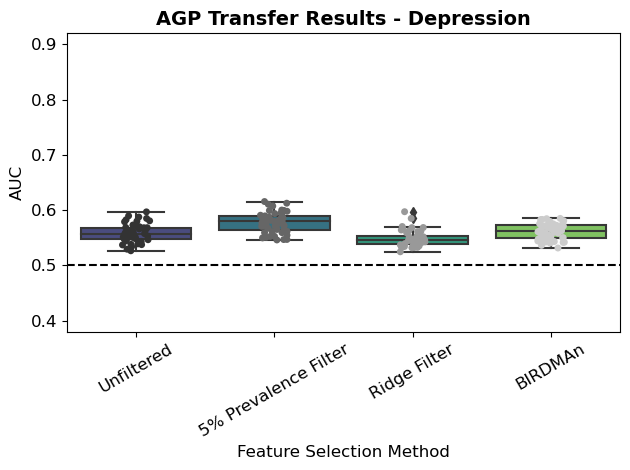

In [18]:
sns.boxplot(data=rf_results_agp, x='feature_selection', y='auc', palette='viridis')
sns.stripplot(data=rf_results_agp, x='feature_selection', y='auc',
              palette='gray')
ax = plt.gca()
plt.title('AGP Transfer Results - Depression', fontdict={'weight': 'bold', 'size': 14})
ax.hlines(y=0.5, xmin=-0.5, xmax=3.5, color='k', linestyle='--')
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(0.38, 0.92)
plt.ylabel('AUC', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=30)
plt.xlabel('Feature Selection Method', fontsize=12)
plt.tight_layout()
plt.savefig('figs5a.png', transparent=True)

/tmp/ipykernel_43994/3747032787.py:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=rf_results_agp, x='feature_selection', y='apr',


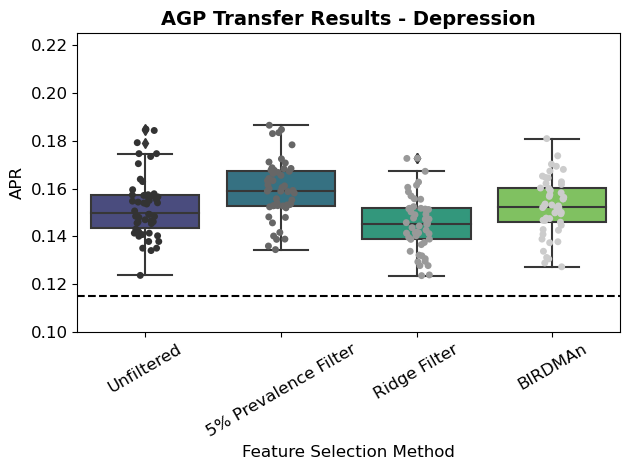

In [19]:
sns.boxplot(data=rf_results_agp, x='feature_selection', y='apr', palette='viridis')
sns.stripplot(data=rf_results_agp, x='feature_selection', y='apr',
              palette='gray')
ax = plt.gca()
plt.title('AGP Transfer Results - Depression', fontdict={'weight': 'bold', 'size': 14})
ax.hlines(y=0.114991, xmin=-0.5, xmax=3.5, color='k', linestyle='--')
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(0.1, 0.225)
plt.ylabel('APR', fontsize=12)
plt.xlabel('Feature Selection Method', fontsize=12)
plt.xticks(fontsize=12, rotation=30)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('figs5b.png', transparent=True)